# PD & ICE

## 초기 설정

In [1]:
from xgboost import XGBClassifier, XGBRegressor
from sklearn.datasets import load_breast_cancer, load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay, plot_partial_dependence

from matplotlib import pyplot as plt
import pandas as pd

## Classification

### 데이터 로드 및 전처리

In [2]:
# scikit-learn의 유방암 데이터 셋 사용
breast_cancer_data = load_breast_cancer()

X = pd.DataFrame(breast_cancer_data.data)
y = pd.DataFrame(breast_cancer_data.target)

In [3]:
# 학습/테스트 데이터 분류 (8:2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
y_train = y_train.values.reshape(-1)
y_test = y_test.values.reshape(-1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((455, 30), (114, 30), (455,), (114,))

### 모델 생성 및 평가

In [4]:
# XGB 분류 모델 생성
classify_xgb = XGBClassifier(n_estimators=100, random_state=3)
classify_xgb.fit(X_train, y_train)

[07:37:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=3,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [5]:
print(f'Train set accuracy: {classify_xgb.score(X_train, y_train):.3f}')
print(f'Test set accuracy: {classify_xgb.score(X_test, y_test):.3f}')

Train set accuracy: 1.000
Test set accuracy: 0.965


### Explaining

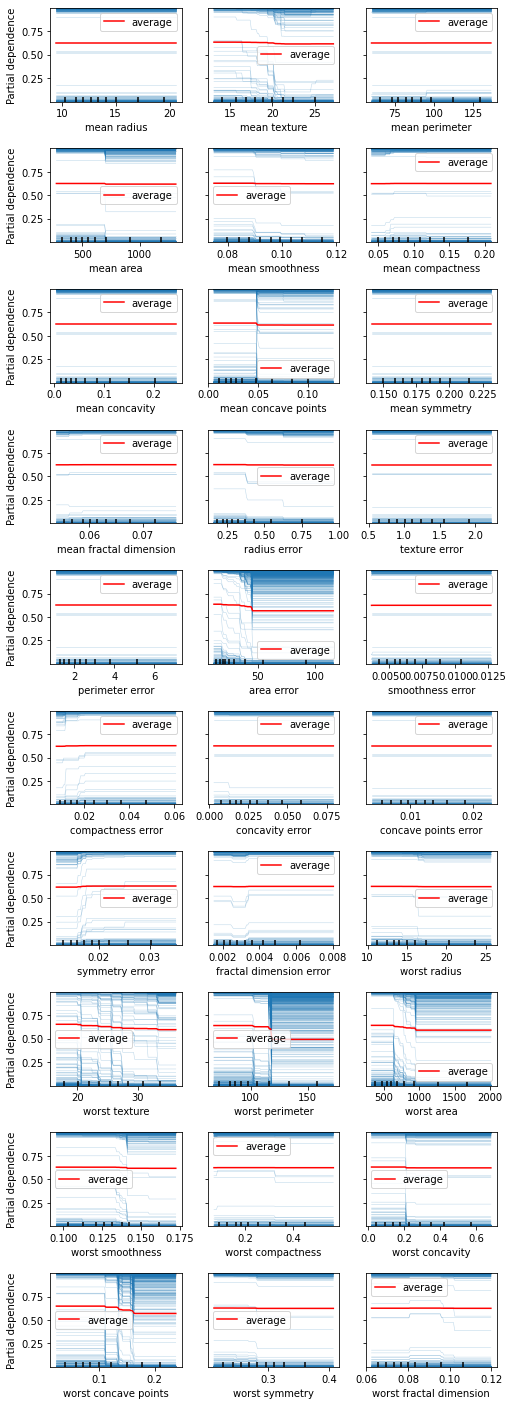

In [6]:
# 모든 feature에 대해 PD & ICE Plot
fig, ax = plt.subplots(figsize=(8, 25))
PartialDependenceDisplay.from_estimator(classify_xgb, 
                                        X=X, features=range(len(X.columns)), 
                                        feature_names=breast_cancer_data.feature_names,
                                        kind='both', ax=ax,
                                        pd_line_kw={'color': 'red'})
plt.subplots_adjust(hspace=0.5)

- 전체 features에 대해 출력했을 때 dependence의 변동률이 적은 경우 거의 수평으로 나옴

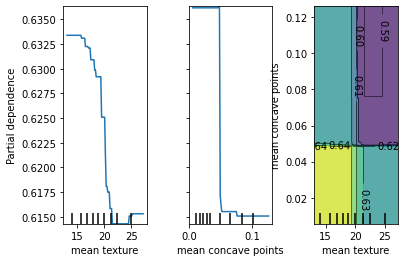

In [7]:
# 1번(mean texture)과 7번(mean concave points)만 비교/시각화
PartialDependenceDisplay.from_estimator(classify_xgb, 
                                        X=X, features=[1, 7, (1, 7)], 
                                        feature_names=breast_cancer_data.feature_names)
plt.subplots_adjust(wspace=0.5)

- 두 변수에 대해 PD를 시각화 한 경우 관계를 알 수 있음
- 두 변수 모두 작을 때 유방암 발생과의 관계가 높음

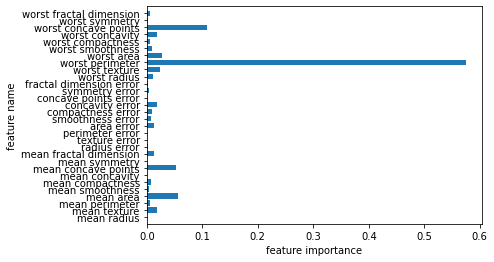

In [8]:
# 결정 트리의 특성 중요도를 시각화
def plot_feature_importance(data, model):
    n_features = len(data.feature_names)
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(range(n_features), data.feature_names)
    plt.xlabel('feature importance')
    plt.ylabel('feature name')
    plt.ylim(-1, n_features)
    plt.show()

plot_feature_importance(breast_cancer_data, classify_xgb)

- 육안상 PDP에서 그래프의 변동이 클수록 importance가 높게 나타나는 경향을 보임

## Regression

### 데이터 로드 및 전처리

In [9]:
# scikit-learn의 당뇨병 데이터
# data의 경우 나이, 성별 등 환자의 특성
# target의 경우 baseline을 기준으로 한 질병의 진행 정도
diabetes_data = load_diabetes()

X = pd.DataFrame(diabetes_data.data)
y = pd.DataFrame(diabetes_data.target)

In [10]:
# 학습/테스트 데이터 분류 (8:2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
y_train = y_train.values.reshape(-1)
y_test = y_test.values.reshape(-1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((353, 10), (89, 10), (353,), (89,))

### 모델 생성 및 평가

In [11]:
# XGB 회귀 모델 생성
regression_xgb = XGBRegressor(n_estimators=100, random_state=3)
regression_xgb.fit(X_train, y_train)

# 학습/테스트 데이터에 대해 성능 평가
print(f'Train set accuracy: {regression_xgb.score(X_train, y_train):.3f}')
print(f'Test set accuracy: {regression_xgb.score(X_test, y_test):.3f}')

Train set accuracy: 1.000
Test set accuracy: 0.329


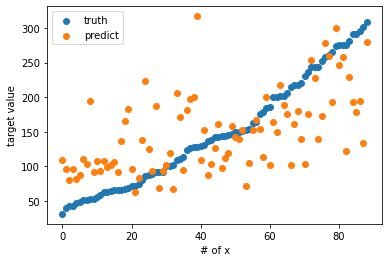

In [12]:
# 모델 예측 결과 확인을 위해 테스트의 타겟/예측 데이터 정렬
pred_test = regression_xgb.predict(X_test)
test_sort_indices = y_test.reshape(-1).argsort()
y_test_sort = y_test[test_sort_indices]
pred_test_sort = pred_test[test_sort_indices]

# 테스트 데이터에 대한 타겟/예측 값 확인
plt.scatter(range(len(y_test)), y_test_sort, label='truth')
plt.scatter(range(len(y_test)), pred_test_sort, label='predict')
plt.xlabel('# of x')
plt.ylabel('target value')
plt.legend()
plt.show()

### Explaining

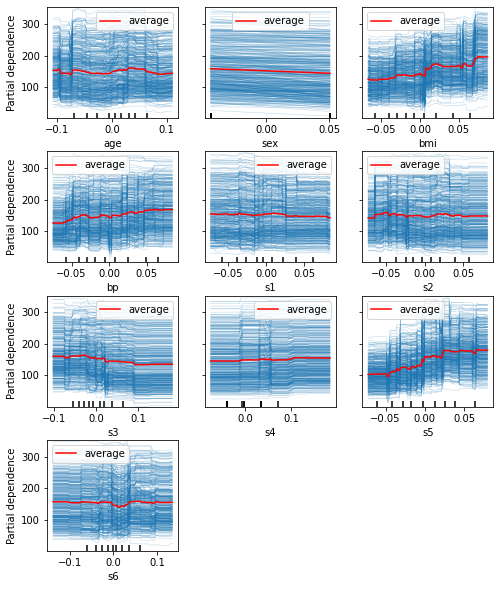

In [13]:
fig, ax = plt.subplots(figsize=(8, 10))
PartialDependenceDisplay.from_estimator(regression_xgb, 
                                        X=X, features=range(len(X.columns)), 
                                        feature_names=diabetes_data.feature_names,
                                        kind='both', ax=ax,
                                        pd_line_kw={'color': 'red'})
plt.subplots_adjust(hspace=0.3)
plt.show()

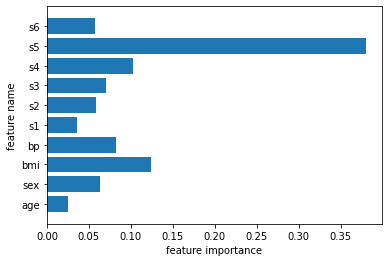

In [14]:
plot_feature_importance(diabetes_data, regression_xgb)

- 분류 때와 유사하게 PDP의 변동률이 클수록 importance가 높게 나타나는 경향을 보임